# Alibi interpretability demo

## Setup

In [1]:
from alibi.explainers import ALE, PartialDependence, plot_ale, plot_pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
random_seed = 42
np.random.seed(random_seed)

## Datasets

In [3]:
class DatasetSplits:
    feature_names: list[str]
    target_names: list[str]
    X_train: np.ndarray
    X_test: np.ndarray
    y_train: np.ndarray
    y_test: np.ndarray

    def __init__(
        self,
        feature_names: list[str],
        target_names: list[str],
        data: DataFrame,
        target: DataFrame,
        test_size: float = 0.2,
        random_state: int = random_seed,
    ) -> None:
        self.feature_names = feature_names
        self.target_names = target_names
        X_train, X_test, y_train, y_test = train_test_split(
            data.to_numpy(),
            target.to_numpy(),
            test_size=test_size,
            random_state=random_state,
        )
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

### California Housing

This dataset is used to demonstrate regression problems.

In [4]:
california_housing = fetch_california_housing(as_frame=True)
california_housing_dataset = DatasetSplits(
    california_housing.feature_names,
    california_housing.target_names,
    california_housing.data,
    california_housing.target,
)
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


## Models

In [5]:
def plot_predictions(dataset: DatasetSplits, y_pred: np.ndarray) -> None:
    _, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
    axes = axes.flatten()

    for i, axis in enumerate(axes):
        if i < len(dataset.feature_names):
            axis.scatter(
                dataset.X_test[:, i],
                dataset.y_test,
                color="blue",
                label=dataset.feature_names[i],
            )
            axis.scatter(
                dataset.X_test[:, i],
                y_pred,
                color="red",
                alpha=0.5,
                label="Prediction",
            )
            axis.set_title(f"Housing Prices by {dataset.feature_names[i]}")
            axis.set_xlabel(dataset.feature_names[i])
            axis.set_ylabel("Housing Price")
            axis.legend()
        else:
            axis.axis("off")

    plt.tight_layout()
    plt.show()

### Linear Regression

In [6]:
linear_regressor = LinearRegression()
linear_regressor.fit(
    california_housing_dataset.X_train, california_housing_dataset.y_train
)

LinearRegression()

Train Score: 0.6125511913966952; Test Score: 0.5757877060324524; MSE: 0.5558915986952422


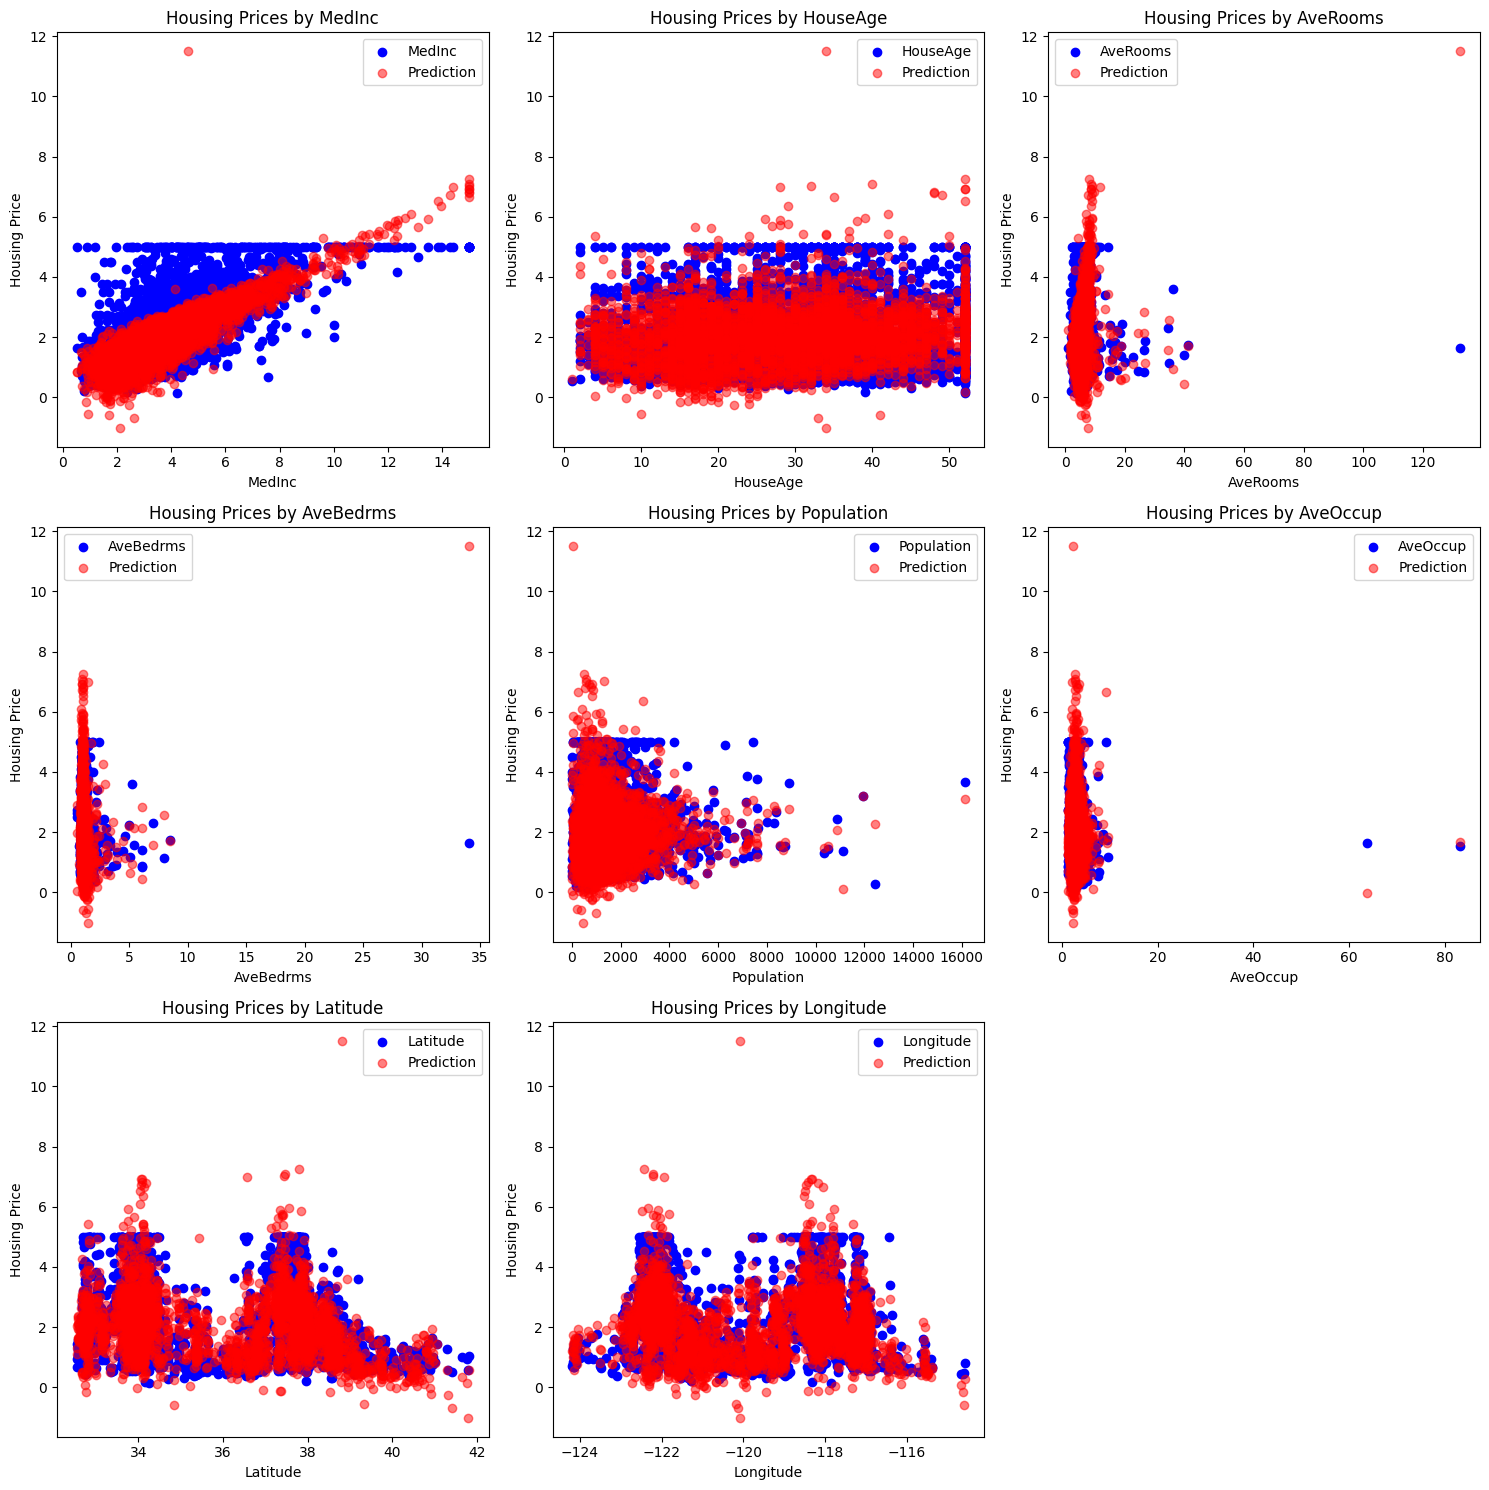

In [7]:
linear_regressor_y_pred = linear_regressor.predict(california_housing_dataset.X_test)
linear_regressor_train_score = linear_regressor.score(
    california_housing_dataset.X_train, california_housing_dataset.y_train
)
linear_regressor_test_score = linear_regressor.score(
    california_housing_dataset.X_test, california_housing_dataset.y_test
)
linear_regressor_mse = mean_squared_error(
    california_housing_dataset.y_test, linear_regressor_y_pred
)
print(
    f"Train Score: {linear_regressor_train_score}; Test Score: {linear_regressor_test_score}; MSE: {linear_regressor_mse}"
)
plot_predictions(california_housing_dataset, linear_regressor_y_pred)

### Random Forest

In [8]:
random_forest_regressor = RandomForestRegressor()
random_forest_regressor.fit(
    california_housing_dataset.X_train, california_housing_dataset.y_train
)

RandomForestRegressor()

Train Score: 0.9735469885313961; Test Score: 0.8048502475905297; MSE: 0.2557259876588585


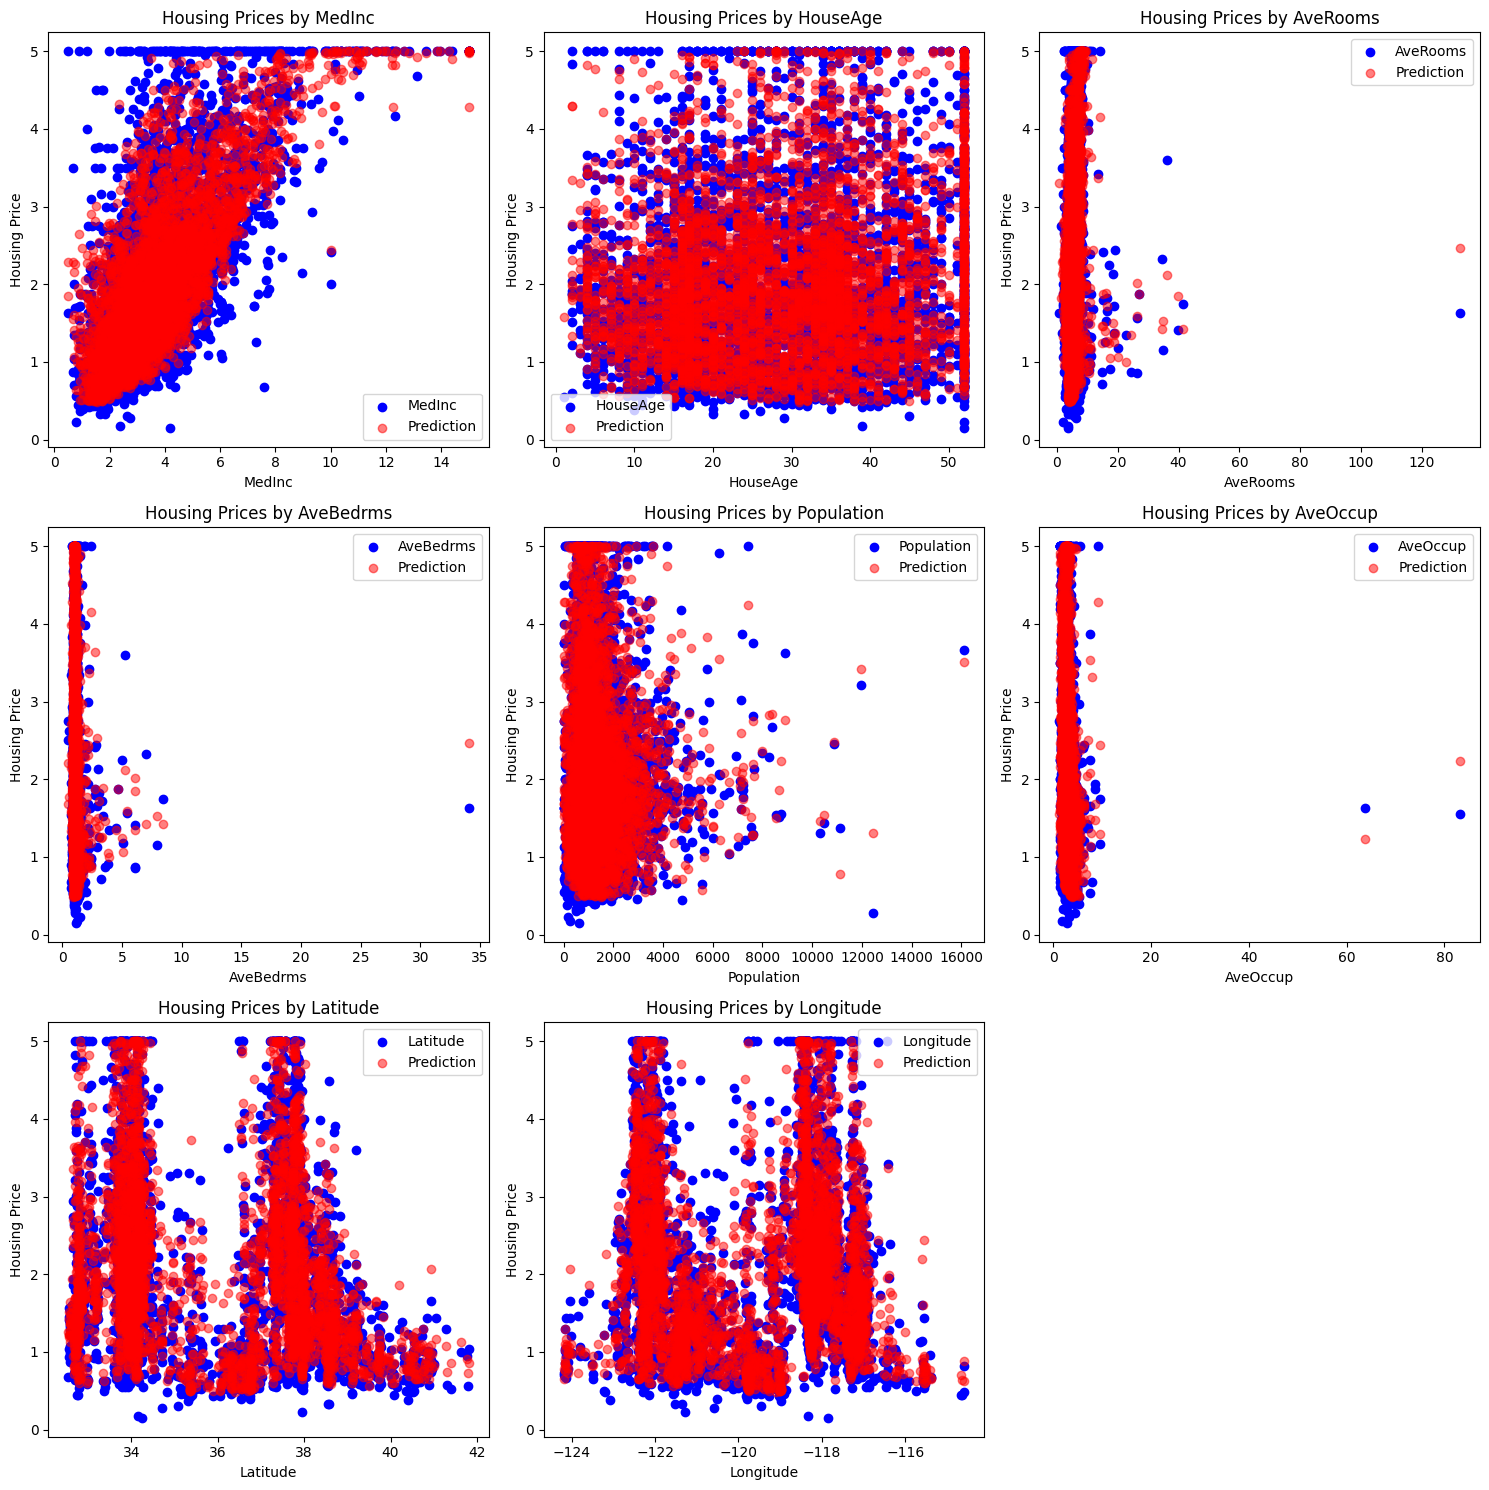

In [9]:
random_forest_regressor_y_pred = random_forest_regressor.predict(california_housing_dataset.X_test)
random_forest_regressor_train_score = random_forest_regressor.score(california_housing_dataset.X_train, california_housing_dataset.y_train)
random_forest_regressor_test_score = random_forest_regressor.score(california_housing_dataset.X_test, california_housing_dataset.y_test)
random_forest_regressor_mse = mean_squared_error(california_housing_dataset.y_test, random_forest_regressor_y_pred)
print(
    f"Train Score: {random_forest_regressor_train_score}; Test Score: {random_forest_regressor_test_score}; MSE: {random_forest_regressor_mse}"
)
plot_predictions(california_housing_dataset, random_forest_regressor_y_pred)

## Explainers

### Accumulated Local Effects (ALE)

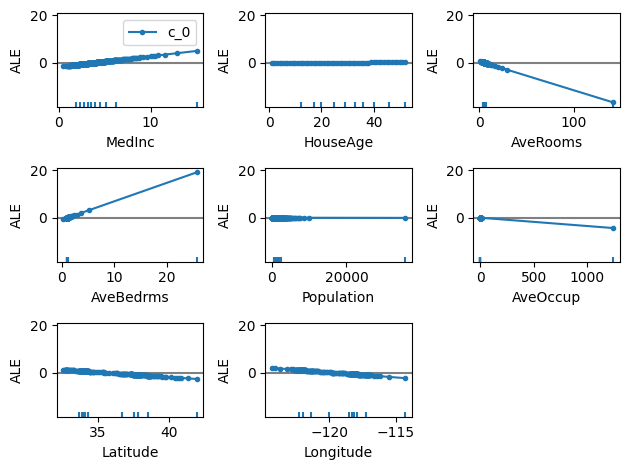

In [10]:
linear_regressor_ale_explainer = ALE(linear_regressor.predict, feature_names=california_housing_dataset.feature_names)
linear_regressor_ale_explanation = linear_regressor_ale_explainer.explain(california_housing_dataset.X_train)
plot_ale(linear_regressor_ale_explanation);

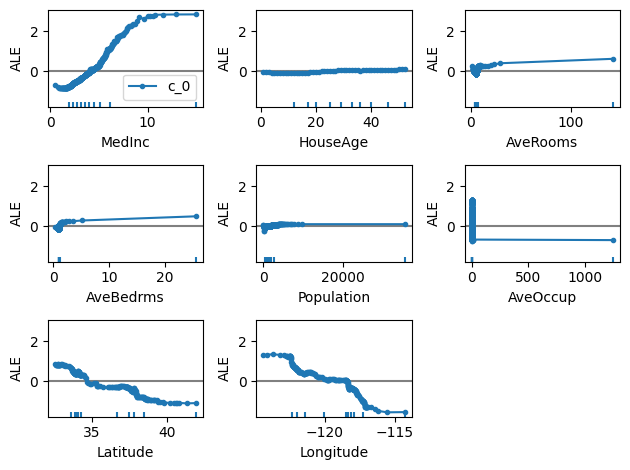

In [11]:
random_forest_regressor_ale_explainer = ALE(
    random_forest_regressor.predict, feature_names=california_housing_dataset.feature_names
)
random_forest_regressor_ale_explanation = random_forest_regressor_ale_explainer.explain(
    california_housing_dataset.X_train
)
plot_ale(random_forest_regressor_ale_explanation);

### Partial Dependence Plot (PDP)

In [12]:
num_examples = 100
pdp_features = [
    (
        california_housing_dataset.feature_names.index("AveBedrms"),
        california_housing_dataset.feature_names.index("MedInc"),
    ),
    (
        california_housing_dataset.feature_names.index("Longitude"),
        california_housing_dataset.feature_names.index("Latitude"),
    ),
]

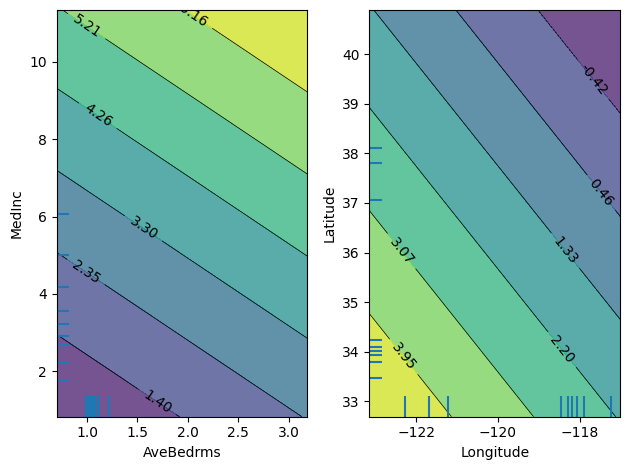

In [13]:
linear_regressor_pdp_explainer = PartialDependence(linear_regressor.predict, feature_names=california_housing_dataset.feature_names, target_names=california_housing.target_names)
linear_regressor_pdp_explanation = linear_regressor_pdp_explainer.explain(california_housing_dataset.X_train[:num_examples], features=pdp_features)
plot_pd(linear_regressor_pdp_explanation);

array([[<Axes: xlabel='AveBedrms', ylabel='MedInc'>,
        <Axes: xlabel='Longitude', ylabel='Latitude'>]], dtype=object)

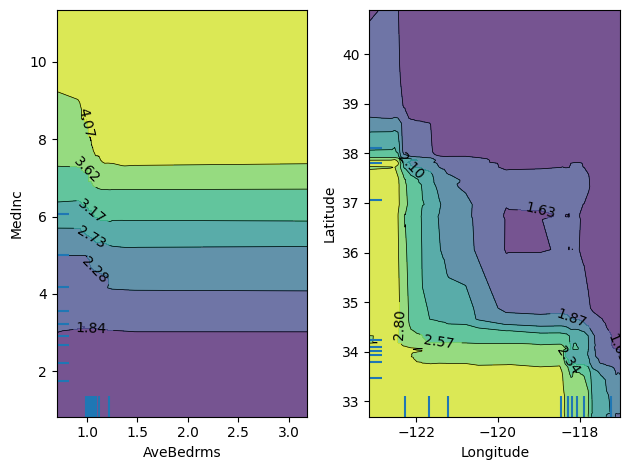

In [14]:
random_forest_regressor_pdp_explainer = PartialDependence(
    random_forest_regressor.predict,
    feature_names=california_housing_dataset.feature_names,
    target_names=california_housing.target_names,
)
random_forest_regressor_pdp_explanation = random_forest_regressor_pdp_explainer.explain(
    california_housing_dataset.X_train[:num_examples], features=pdp_features
)
plot_pd(random_forest_regressor_pdp_explanation);